In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
usdata = pd.read_pickle("clean_us.pkl")
usdata.head(n=2)

,trending_date,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_date,token_title,token_description
0,2017-11-14,CaseyNeistat,22,17:13:01,[SHANtell martin],748374,57527,2966,15954,False,False,False,2017-11-13,"[we, want, to, talk, about, our, marriage]","[shantell, 's, channel, -, -, this, video, in,..."
1,2017-11-14,LastWeekTonight,24,07:30:00,"[last week tonight trump presidency, last week...",2418783,97185,6146,12703,False,False,False,2017-11-13,"[the, trump, presidency, last, week, tonight, ...","[one, year, after, the, presidential, election..."


In [3]:
usdata.columns

Index(['trending_date', 'channel_title', 'category_id', 'publish_time', 'tags',
       'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled',
       'ratings_disabled', 'video_error_or_removed', 'publish_date',
       'token_title', 'token_description'],
      dtype='object')

In [4]:
usdata.shape

(7139, 15)

In [33]:
#load categorical data
with open ("US_categories.pickle","rb") as f:
    categories = pickle.load(f)
print(categories)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [6]:
#Makes a subset of categories present in the dataset
cat_name_to_cat_id = {j:i for i,j in categories.items() if i in set(usdata["category_id"])}
cat_id_to_cat_name = {j:i for i,j in cat_name_to_cat_id.items()}

### Exploratory data analysis 

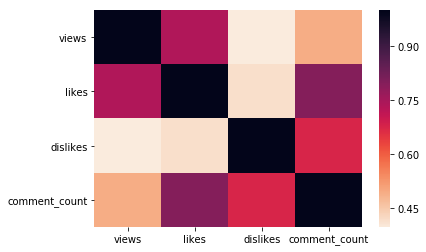

In [7]:
sub = usdata[["views", "likes", "dislikes", "comment_count"]]
corr = sub.corr()
cmap = sns.cm.rocket_r
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap=cmap,
           annot=True)



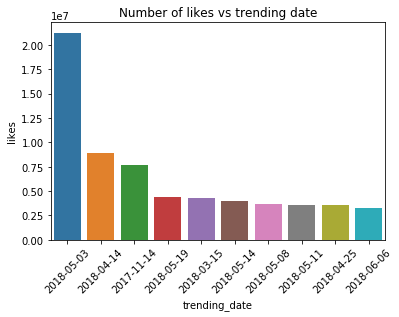

In [8]:
#plt.hist(usdata.trending_date)
reactions = usdata.groupby("trending_date").agg({"likes":"sum", "dislikes":"sum"}).\
sort_values("likes",ascending=False).reset_index()[:10]
#plt.plot(reactions["trending_date"],reactions["likes"])
sns.barplot(reactions["trending_date"].dt.date,reactions["likes"])
plt.xticks(rotation=45)
plt.title("Number of likes vs trending date")
plt.show()

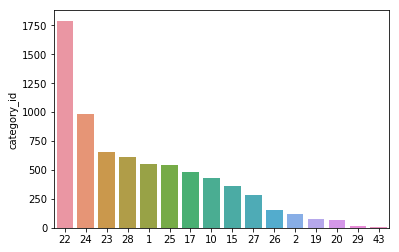

In [9]:
sns.barplot(usdata["category_id"].unique(),usdata["category_id"].value_counts())

#The most common category is People & Blogs, followed by Entertainment.

#usdata["category_id"].value_counts().plot()

In [10]:
print(cat_name_to_cat_id)

{'Film & Animation': 1, 'Autos & Vehicles': 2, 'Music': 10, 'Pets & Animals': 15, 'Sports': 17, 'Travel & Events': 19, 'Gaming': 20, 'People & Blogs': 22, 'Comedy': 23, 'Entertainment': 24, 'News & Politics': 25, 'Howto & Style': 26, 'Education': 27, 'Science & Technology': 28, 'Nonprofits & Activism': 29, 'Shows': 43}


#### What is the relationship between trending date and the time of publication?


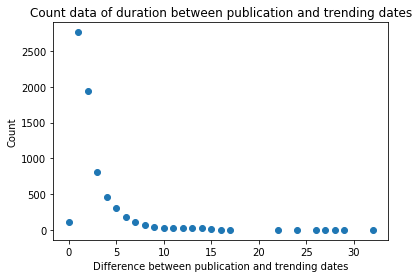

In [11]:
xx = (usdata["trending_date"] - usdata["publish_date"]).astype('timedelta64[D]').value_counts().reset_index()
xx.rename(index=str, columns={"index": "Diff", 0: "count"},inplace=True)
plt.scatter(xx["Diff"][:25], xx["count"][:25])
plt.xlabel("Difference between publication and trending dates")
plt.ylabel("Count")
plt.title("Count data of duration between publication and trending dates")
plt.show()
#xx.head()

In [12]:
grp_cats = usdata.groupby("category_id")
#(grp_cats["trending_date"] - grp_cats["publish_date"]).astype('timedelta64[D]').value_counts().reset_index()


#finish grouping by category and look at the differences between publication and trending dates

#### How similar are the various categories to each other?

In [34]:
mg_cat = usdata.groupby("category_id").agg({"tags":"sum"}).reset_index()

In [14]:
#index category id
ind_to_cat_id = {idx:cat for idx, cat in enumerate(usdata.category_id.unique())}
cat_id_to_ind = {j:i for i,j in ind_to_cat_id.items()}

In [15]:
n_feats = 5000
doc_by_vocab = np.empty([len(mg_cat), n_feats])

def build_vectorizer(max_features, stop_words, max_df=0.8, min_df=10, norm='l2'):
    """Returns a TfidfVectorizer object with the above preprocessing properties.
    
    Params: {max_features: Integer,
             max_df: Float,
             min_df: Float,
             norm: String,
             stop_words: String}
    Returns: TfidfVectorizer
    """
    # YOUR CODE HERE
    tfidfvec = TfidfVectorizer(max_features = max_features, stop_words = stop_words, \
                    max_df = max_df, min_df = min_df, norm=norm)
    return tfidfvec

tfidf_vec = build_vectorizer(n_feats, "english")
doc_by_vocab = tfidf_vec.fit_transform([", ".join(d) for d in mg_cat["tags"]]).toarray()
index_to_vocab = {i:v for i, v in enumerate(tfidf_vec.get_feature_names())}

In [16]:
def get_sim(cat1, cat2, input_doc_mat, cat_name_to_cat_id, cat_id_to_ind):
    """Returns a float giving the cosine similarity of 
       the two categories.
    
    Params: {mov1: String,
             mov2: String,
             input_doc_mat: Numpy Array,
             movie_name_to_index: Dict}
    Returns: Float (Cosine similarity of the two movie transcripts.)
    """
    # YOUR CODE HERE
    catid_1 = cat_name_to_cat_id[cat1]
    catid_2 = cat_name_to_cat_id[cat2]

    script_1 = input_doc_mat[cat_id_to_ind[catid_1],]
    script_2 = input_doc_mat[cat_id_to_ind[catid_2],]
    
    val = np.dot(script_1,script_2.T)/(np.linalg.norm(script_1)*np.linalg.norm(script_2))
        
    return val


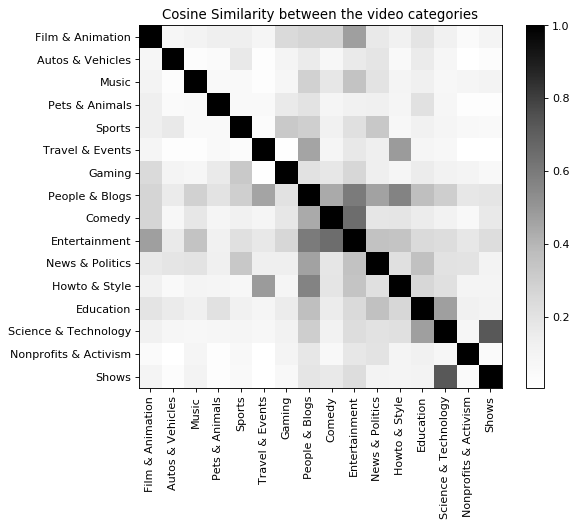

In [35]:
cossim_cat = np.zeros(shape=(len(cat_name_to_cat_id),len(cat_name_to_cat_id)))

for name1,i in cat_name_to_cat_id.items():
    for name2,j in cat_name_to_cat_id.items():
        row = cat_id_to_ind[i]
        col = cat_id_to_ind[j]
        cossim_cat[row,col] = get_sim(name1, name2, doc_by_vocab, cat_name_to_cat_id, cat_id_to_ind)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(cossim_cat, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()
plt.title("Cosine Similarity between the video categories")
plt.xticks(range(len(cat_name_to_cat_id)), cat_name_to_cat_id.keys(), rotation=90)
plt.yticks(range(len(cat_name_to_cat_id)), cat_name_to_cat_id.keys())
plt.show()

In [32]:
for i in range(cossim_cat.shape[0]):
    print(cat_id_to_cat_name[ind_to_cat_id[i]])
    print("---------------------------")
    top3_idx = np.argsort(cossim_cat[i])[::-1][1:4]
    top3_num = np.sort(cossim_cat[i])[::-1][1:4]
    for j,num in zip(top3_idx,top3_num):
        print(cat_id_to_cat_name[ind_to_cat_id[j]] + " - " + str(num))
    print(" ")

People & Blogs
---------------------------
Education - 0.47246933153092907
Pets & Animals - 0.2704451966263699
Music - 0.2690766805068113
 
Entertainment
---------------------------
Howto & Style - 0.18471607486707015
Film & Animation - 0.16458201129687144
Education - 0.1596396216117472
 
Comedy
---------------------------
Education - 0.34938933206202416
Music - 0.28751728962137224
Howto & Style - 0.1961459593970734
 
Science & Technology
---------------------------
Travel & Events - 0.20894355517029894
Music - 0.19715521955924709
Sports - 0.15627696867174865
 
Film & Animation
---------------------------
Howto & Style - 0.3240584551920091
Sports - 0.3194932884181183
Music - 0.2924126884849494
 
News & Politics
---------------------------
Autos & Vehicles - 0.4829809833569685
Music - 0.4585112330204882
Education - 0.1693917847444887
 
Sports
---------------------------
Film & Animation - 0.3194932884181183
Education - 0.263588776029997
People & Blogs - 0.2449138154260436
 
Music
------

#### What is the relationship between number of comments and up/down-votes?

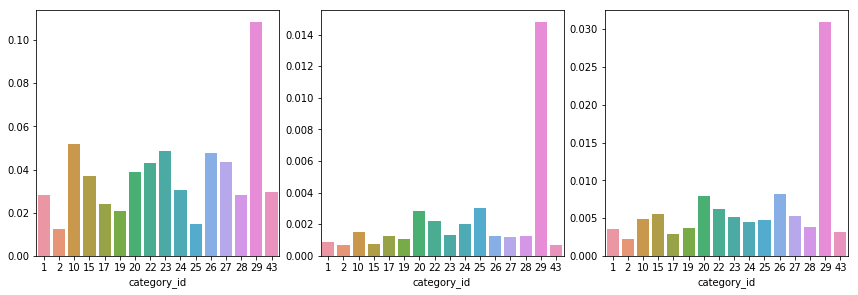

In [59]:

dis_like = usdata.groupby("category_id").agg({"likes":"sum", "dislikes":"sum","views":"sum",\
                                              "comment_count": "sum"}).reset_index()
dis_like
#plt.scatter(np.log(dis_like["likes"]), np.log(dis_like["dislikes"]))



#ig = plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.tight_layout()

plt.subplot(1, 3, 1)
sns.barplot(dis_like["category_id"],dis_like["likes"]/dis_like["views"])
plt.ylabel("Ratio of ")

plt.subplot(1, 3, 2)
sns.barplot(dis_like["category_id"],dis_like["dislikes"]/dis_like["views"])

plt.subplot(1, 3, 3)
sns.barplot(dis_like["category_id"],dis_like["comment_count"]/dis_like["views"])

plt.show()




# sns.barplot(dis_like["category_id"],dis_like["dislikes"]/dis_like["views"])
# sns.barplot(dis_like["category_id"],dis_like["comment_count"]/dis_like["views"])
# plt.show()